
Training Word2Vec model...
Word2Vec model trained successfully

Analyzing policy similarities...

Policy Text Similarity Analysis:
avg_similarity: 0.984
min_similarity: 0.905
max_similarity: 0.999

Analyzing policy distribution...

Extended keywords using Word2Vec:

Academic Misconduct:
Original keywords: ['exam', 'test', 'grade', 'copying', 'malpractice', 'cheating', 'plagiarism']
Extended keywords: ['module', 'be', '2024', 'to', 'for', 'students', 'with', 'and', 'in', 'of', 'pm', 'the', 'is']

Library Rules:
Original keywords: ['library', 'books', 'journal', 'reading', 'borrowing']
Extended keywords: ['2024', 'for', 'and', 'in', 'the']

General Discipline:
Original keywords: ['attendance', 'dress', 'behavior', 'conduct', 'discipline']
Extended keywords: ['be', 'for', 'with', 'and', 'the']

Placement Related:
Original keywords: ['placement', 'interview', 'company', 'recruitment', 'job']
Extended keywords: ['2024', 'be', 'for', 'students', 'and', 'in', 'of', '1', 'the', 'any']

Other 

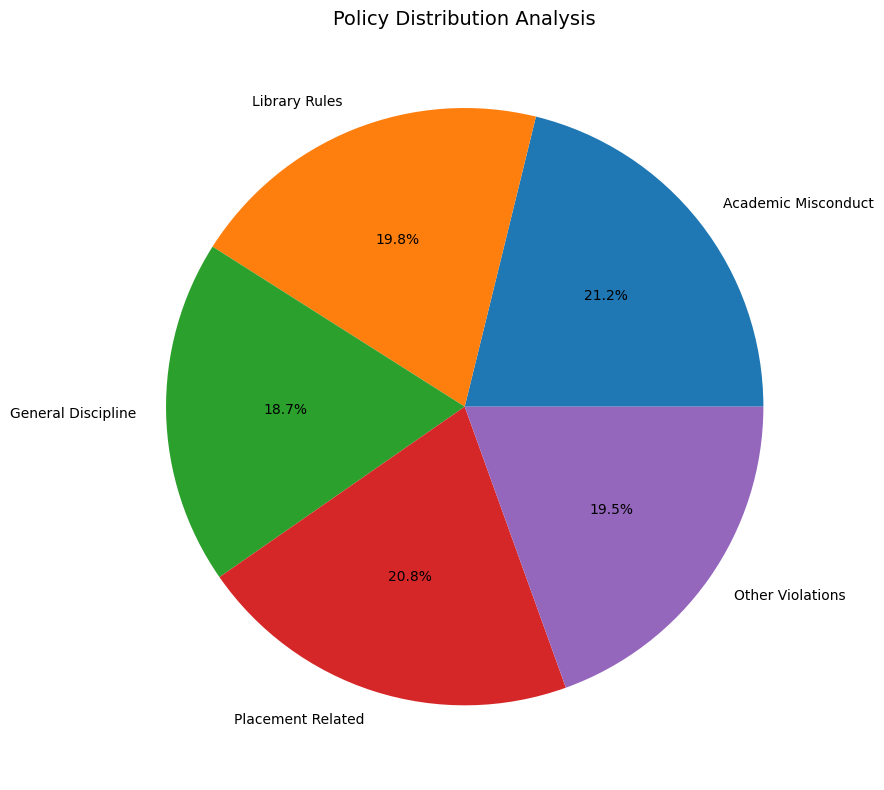

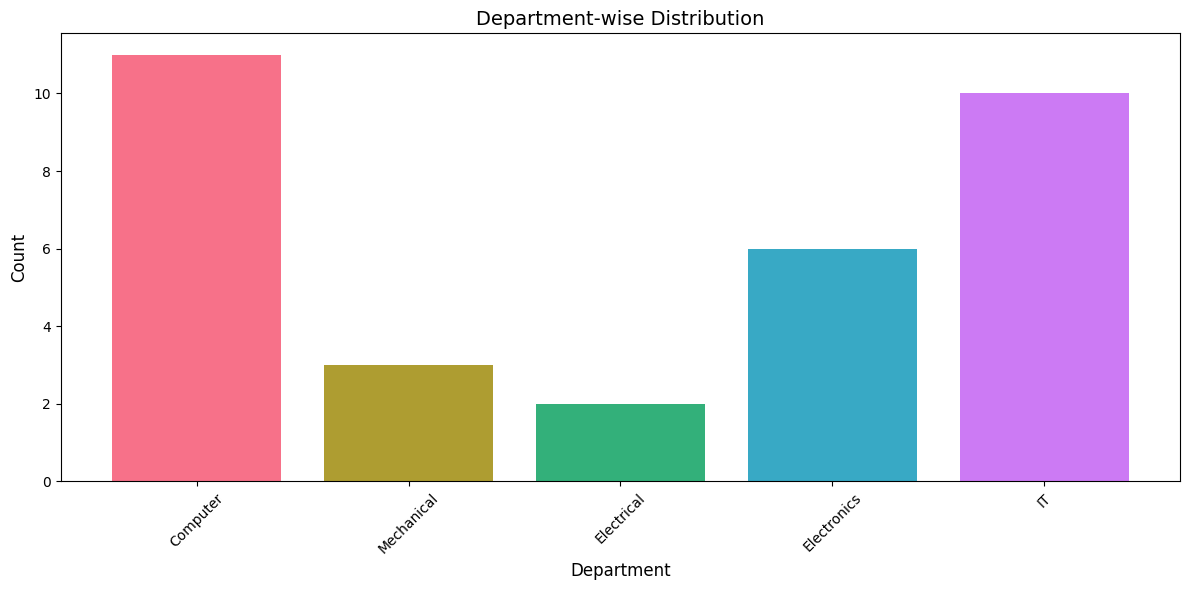

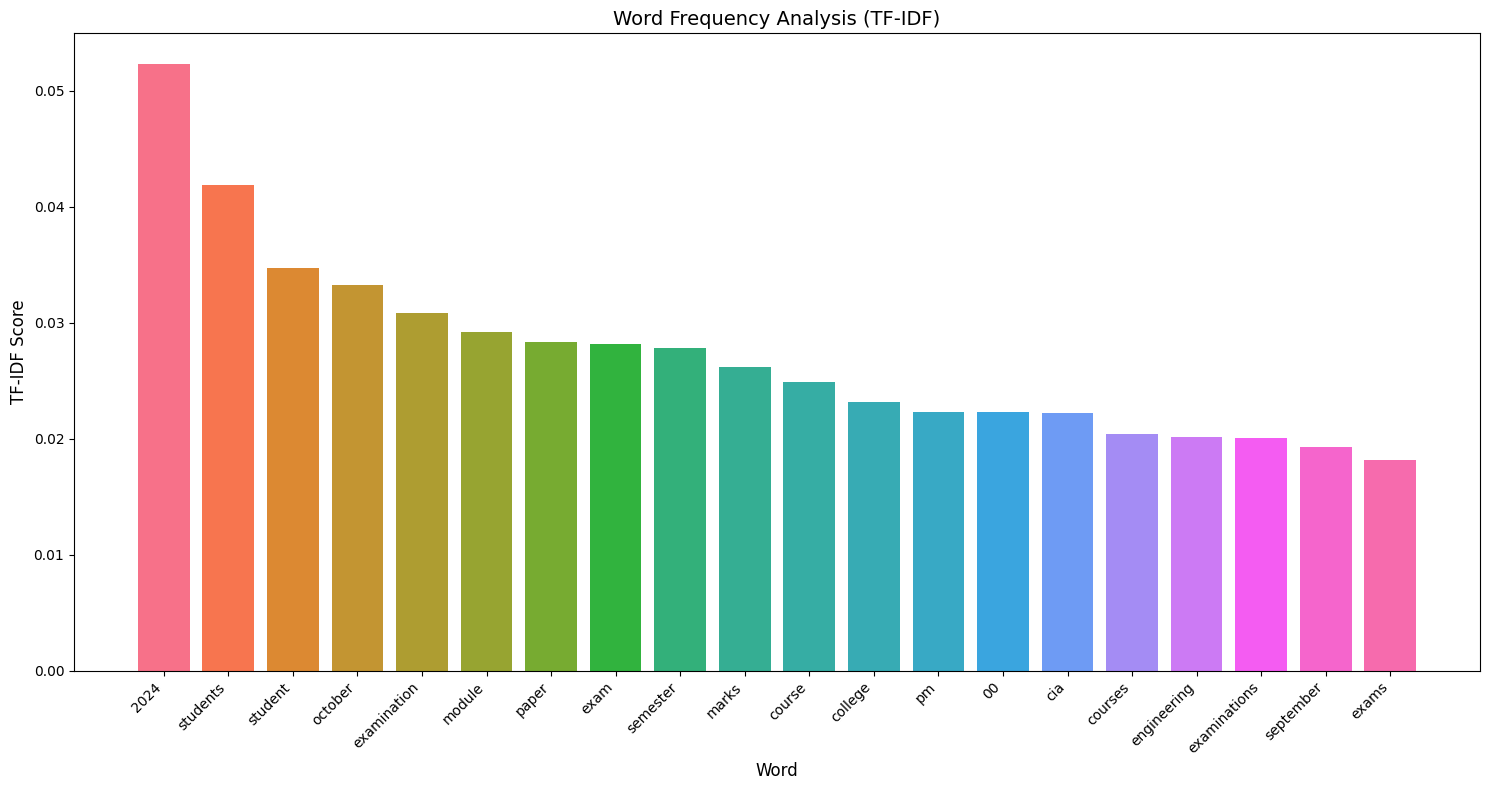


Top 10 Most Important Terms (TF-IDF):
            word  frequency
39          2024   0.052353
870     students   0.041873
868      student   0.034693
563      october   0.033292
419  examination   0.030857
544       module   0.029235
593        paper   0.028375
418         exam   0.028143
800     semester   0.027829
522        marks   0.026179

Analysis completed successfully!


In [11]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from gensim.models import Word2Vec

def download_nltk_data():
    """Download required NLTK data"""
    required_packages = ['punkt', 'stopwords', 'averaged_perceptron_tagger']
    for package in required_packages:
        try:
            nltk.download(package, quiet=True)
        except Exception as e:
            print(f"Error downloading {package}: {e}")

def get_stop_words():
    """Get combined stop words from multiple sources"""
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    custom_stops = ['fcrit', 'fr', 'c', 'rodrigues', 'institute', 'technology']
    return list(ENGLISH_STOP_WORDS) + stopwords.words('english') + custom_stops

def preprocess_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""
    # Remove special characters but keep spaces
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def get_similar_words(w2v_model, keywords, threshold=0.6):
    """
    Get similar words from Word2Vec model based on cosine similarity
    """
    if not w2v_model:
        return keywords

    extended_keywords = set(keywords)
    for word in keywords:
        try:
            # Find similar words based on the trained model
            similar_words = w2v_model.wv.most_similar(word, topn=5)
            # Add words that meet the similarity threshold
            extended_keywords.update(
                word for word, score in similar_words
                if score >= threshold
            )
        except KeyError:
            continue
    return list(extended_keywords)

def extract_policy_distribution(texts, w2v_model=None):
    """Categorize policies using keyword matching enhanced with Word2Vec"""
    base_categories = {
        'Academic Misconduct': ['exam', 'test', 'grade', 'copying', 'malpractice', 'cheating', 'plagiarism'],
        'Library Rules': ['library', 'books', 'journal', 'reading', 'borrowing'],
        'General Discipline': ['attendance', 'dress', 'behavior', 'conduct', 'discipline'],
        'Placement Related': ['placement', 'interview', 'company', 'recruitment', 'job'],
        'Other Violations': ['ragging', 'harassment', 'damage', 'misconduct']
    }

    # Extend keywords using Word2Vec if model is available
    categories = {
        category: get_similar_words(w2v_model, keywords)
        for category, keywords in base_categories.items()
    }

    # Print extended keywords for inspection
    if w2v_model:
        print("\nExtended keywords using Word2Vec:")
        for category, keywords in categories.items():
            print(f"\n{category}:")
            print(f"Original keywords: {base_categories[category]}")
            print(f"Extended keywords: {list(set(keywords) - set(base_categories[category]))}")

    category_counts = {cat: 0 for cat in categories}

    for text in texts:
        text = preprocess_text(text)
        text_tokens = set(word_tokenize(text))  # Tokenize once for efficiency

        for category, keywords in categories.items():
            # Check for keyword matches in tokenized text
            if any(keyword in text_tokens for keyword in keywords):
                category_counts[category] += 1

    total = sum(category_counts.values())
    if total == 0:
        return {k: 0 for k in categories}

    return {k: (v / total) * 100 for k, v in category_counts.items()}

def extract_department_info(texts):
    """Extract department-related mentions"""
    dept_patterns = {
        'Computer': r'\b(computer|comp)\b',
        'Mechanical': r'\b(mechanical|mech)\b',
        'Electrical': r'\b(electrical|elect)\b',
        'Electronics': r'\b(electronics|etc)\b',
        'IT': r'\b(information technology|it)\b'
    }

    dept_counts = {dept: 0 for dept in dept_patterns}

    for text in texts:
        if not isinstance(text, str):
            continue
        text = text.lower()
        for dept, pattern in dept_patterns.items():
            if re.search(pattern, text):
                dept_counts[dept] += 1

    return dept_counts

def get_word_frequency_tfidf(texts, n_words=20):
    """Calculate word frequency using TF-IDF"""
    valid_texts = [preprocess_text(text) for text in texts if isinstance(text, str) and text.strip()]

    if not valid_texts:
        return pd.DataFrame(columns=['word', 'frequency'])

    try:
        tfidf = TfidfVectorizer(stop_words=get_stop_words(), max_features=1000)
        tfidf_matrix = tfidf.fit_transform(valid_texts)

        feature_names = tfidf.get_feature_names_out()
        avg_scores = np.mean(tfidf_matrix.toarray(), axis=0)

        word_freq_df = pd.DataFrame({
            'word': feature_names,
            'frequency': avg_scores
        }).sort_values('frequency', ascending=False)

        return word_freq_df.head(n_words)
    except ValueError as e:
        print(f"Error in TF-IDF calculation: {e}")
        return pd.DataFrame(columns=['word', 'frequency'])

def train_word2vec(texts):
    """Train Word2Vec model"""
    valid_texts = [text for text in texts if isinstance(text, str) and text.strip()]
    if not valid_texts:
        return None

    try:
        tokenized_texts = [word_tokenize(preprocess_text(text)) for text in valid_texts]
        model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
        return model
    except Exception as e:
        print(f"Error training Word2Vec model: {e}")
        return None

def analyze_policy_similarity(texts, w2v_model):
    """
    Analyze policy text similarities using Word2Vec embeddings
    """
    if not w2v_model:
        return None

    def get_text_vector(text):
        """Get average vector for text"""
        words = word_tokenize(preprocess_text(text))
        vectors = []
        for word in words:
            try:
                vectors.append(w2v_model.wv[word])
            except KeyError:
                continue
        return np.mean(vectors, axis=0) if vectors else None

    # Get vector representations for each text
    text_vectors = [get_text_vector(text) for text in texts]
    text_vectors = [v for v in text_vectors if v is not None]

    if not text_vectors:
        return None

    # Calculate average similarity between texts
    similarities = []
    for i in range(len(text_vectors)):
        for j in range(i + 1, len(text_vectors)):
            similarity = np.dot(text_vectors[i], text_vectors[j]) / (
                np.linalg.norm(text_vectors[i]) * np.linalg.norm(text_vectors[j])
            )
            similarities.append(similarity)

    return {
        'avg_similarity': np.mean(similarities),
        'min_similarity': np.min(similarities),
        'max_similarity': np.max(similarities)
    }

def plot_results(policy_dist, dept_dist, word_freq):
    """Plot analysis results"""
    # Set the style to a default matplotlib style
    plt.style.use('default')

    # Set common visual parameters
    plt.rcParams.update({
        'figure.autolayout': True,
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 14
    })

    # Policy Distribution Plot
    plt.figure(figsize=(12, 8))
    values = list(policy_dist.values())
    labels = list(policy_dist.keys())
    if any(values):  # Only plot if there are non-zero values
        plt.pie(values, labels=labels, autopct='%1.1f%%',
                textprops={'fontsize': 10})
        plt.title('Policy Distribution Analysis')
        plt.savefig('policy_distribution_nlp.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Department Distribution Plot
    plt.figure(figsize=(12, 6))
    plt.bar(list(dept_dist.keys()), list(dept_dist.values()),
            color=sns.color_palette("husl", len(dept_dist)))
    plt.title('Department-wise Distribution')
    plt.xlabel('Department')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('department_distribution_nlp.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Word Frequency Plot
    if not word_freq.empty:
        plt.figure(figsize=(15, 8))
        plt.bar(word_freq['word'], word_freq['frequency'],
                color=sns.color_palette("husl", len(word_freq)))
        plt.title('Word Frequency Analysis (TF-IDF)')
        plt.xlabel('Word')
        plt.ylabel('TF-IDF Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('word_frequency_nlp.png', bbox_inches='tight', dpi=300)
    plt.show()

def main():
    """Main function"""
    try:
        # Initialize NLTK data
        download_nltk_data()

        # Load and validate data
        df = pd.read_csv('newdataset.csv', encoding='latin1', on_bad_lines='skip')
        if 'Data' not in df.columns:
            raise ValueError("The dataset does not contain a column named 'Data'")

        texts = df['Data'].fillna('').tolist()

        # Train Word2Vec model
        print("\nTraining Word2Vec model...")
        w2v_model = train_word2vec(texts)

        if w2v_model:
            print("Word2Vec model trained successfully")
            # Analyze policy similarities
            print("\nAnalyzing policy similarities...")
            similarity_stats = analyze_policy_similarity(texts, w2v_model)
            if similarity_stats:
                print("\nPolicy Text Similarity Analysis:")
                for metric, value in similarity_stats.items():
                    print(f"{metric}: {value:.3f}")
        else:
            print("Warning: Word2Vec model could not be trained")

        # Perform analyses
        print("\nAnalyzing policy distribution...")
        policy_distribution = extract_policy_distribution(texts, w2v_model)

        print("\nAnalyzing department information...")
        department_distribution = extract_department_info(texts)

        print("\nCalculating word frequencies...")
        word_frequencies = get_word_frequency_tfidf(texts)

        # Generate visualizations
        print("\nGenerating visualizations...")
        plot_results(policy_distribution, department_distribution, word_frequencies)

        # Print results
        print("\nTop 10 Most Important Terms (TF-IDF):")
        print(word_frequencies.head(10) if not word_frequencies.empty else "No valid terms found")

        print("\nAnalysis completed successfully!")

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()